In [20]:
import re
import random
import pandas as pd
import hashlib

In [21]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [22]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
C# Basics,290.807727,9.380894,21.626394,31
Azure Private DNS,567.117471,29.848288,53.488523,19
Open Source/GitHub,579.634654,96.605776,174.678210,6
RAG Project,696.045490,43.502843,111.053316,16
Azure AD Authentication,867.492116,66.730163,172.105975,13
Azure Functions + Visual Studio,895.180704,68.860054,280.019676,13
Email Auth and Security,958.935972,79.911331,178.322017,12
Audit Report Tracker (Sharepoint List),973.487403,88.498855,265.808073,11
WSL + Kali Linux,1245.923597,88.994543,374.916224,14
Logging in Python,1413.034674,83.119687,290.960326,17


# Histogram

sum of ages: ~45423.19


<Axes: >

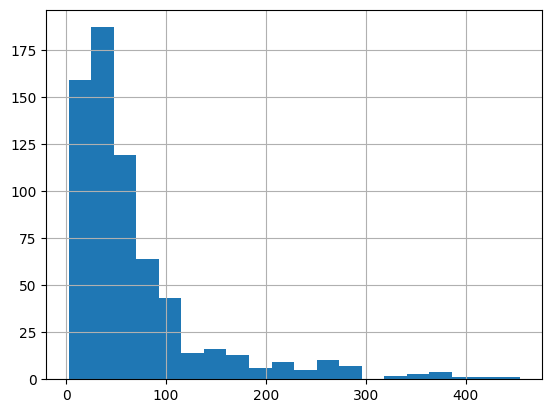

In [23]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [24]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [25]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [26]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [27]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [28]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [29]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [30]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [31]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 664
Total card age: 45423.19


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
145,Vocab,"Lost in a Good Book\nDoric columns: A simple, ...",7f5496b30d95587923948c9509df2835,-453.814282,60.064574,453.814282,-5345.747081,0.152747,0,0
146,Vocab,Lost in a Good Book\nDiatryma: A genus of lar...,6e959c2e1335de1055072946469fda5b,-214.832251,60.064574,453.814282,-5345.747081,0.152747,3,0
147,Vocab,Logogram\nnoun\nSPA: LOG-oh-gram\nIPA: /ˈləʊɡə...,1cc7560e2331db1d559d23688d7d491e,-189.722361,60.064574,453.814282,-5345.747081,0.152747,6,0
376,Vocab,Lost in a Good Book\nEvelyn Waugh (novels): En...,22d9762c0512fd403f50c85fe94c938e,-139.253388,60.064574,453.814282,-5345.747081,0.152747,9,0
149,Vocab,Do Androids Dream of Electric Sheep?\nWimple (...,942eef4be7106352733ed31d882aa5b0,-104.585964,60.064574,453.814282,-5345.747081,0.152747,12,0
150,Vocab,"Well of Lost Plots, Fforde\nRedolent\nadjectiv...",f894df2a303cf73b6d8ad22f00beeceb,-79.404830,60.064574,453.814282,-5345.747081,0.152747,15,0
379,Vocab,Lost in a Good Book\nProleptic: Relating to an...,d0561a09923a7fffdc2c6c1ca5ac8836,-74.689964,60.064574,453.814282,-5345.747081,0.152747,18,0
597,Vocab,Jane Eyre\nCachinnation (kak-ih-NAY-shun)\nLou...,58e426a284d8bc9aba93f7fab28cbd60,-68.415863,60.064574,453.814282,-5345.747081,0.152747,21,0
153,Vocab,"Red Side Story, FForde\nCurtilage\nPronunciati...",2b0003d844a2f8f9f261119a9dafab69,-62.198457,60.064574,453.814282,-5345.747081,0.152747,24,0
154,Vocab,"Well of Lost Plots, Fforde",d721aaaa8e089017e8eee1086c92077f,-54.883164,60.064574,453.814282,-5345.747081,0.152747,27,0


## Age Mean

In [32]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [ ]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
## existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [34]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [35]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [36]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
145,Vocab,"Lost in a Good Book\nDoric columns: A simple, ...",7f5496b30d95587923948c9509df2835,-453.814282,60.064574,453.814282,-5345.747081,0.152747,0,0
122,Azure Developer Associate,What Azure feature should you use to securely ...,f919b56337ef29a1daaa6ec0b63377fe,-421.316902,65.936901,421.316902,-4483.709237,0.667296,0,0
16,Powershell Modules,CurrentUser Scope\n\nDefinition: An installati...,f3d0d03320782899e1352f748fc1cda5,-397.932156,99.926915,397.932156,-4396.784275,0.373405,0,0
33,WSL + Kali Linux,WSLg (Windows Subsystem for Linux GUI)\nA feat...,69051af876862485bdb54d8c645a8a40,-374.916224,88.994543,374.916224,-1245.923597,0.538873,0,0
101,PnP PowerShell,New-PnPList (PnP.PowerShell)\nCreates a new Sh...,9d9dc3700f5078d8eaff9507709eaacb,-368.193605,65.246146,368.193605,-4110.507208,0.877873,0,0
350,Azure Developer Associate,Q: What is Azure Cache for Redis?\nA: A fully ...,5bc9505ae30a8c09e1c0c220c2b6d7b3,-367.649106,65.936901,421.316902,-4483.709237,0.667296,1,1
247,Powershell Modules,Auto-Import\n\nDefinition: A feature in PowerS...,6b1412630951dc5fee8ffa437ee0e0f2,-367.575873,99.926915,397.932156,-4396.784275,0.373405,1,1
49,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,-353.314510,84.115995,353.314510,-4374.031759,0.700171,0,0
470,Powershell Modules,Get-Module\n\nDefinition: A cmdlet that retrie...,0d76065f3213ee411ee6f7e377583cc9,-350.942460,99.926915,397.932156,-4396.784275,0.373405,2,2
83,Terraform,Terraform allows you to manage the resources i...,05fa95392fe5544d07eec6db3a93ccb6,-341.765770,69.645141,341.765770,-1671.483390,0.611211,0,0


In [37]:
existing_cards.head(10).sum()

head                   VocabVocabVocabVocabVocabVocabVocabVocabVocabV...
body                   Lost in a Good Book\nDoric columns: A simple, ...
hash                   7f5496b30d95587923948c9509df28356e959c2e1335de...
age                                                         -1441.800524
subject_mean_age                                              600.645739
subject_highest_age                                          4538.142818
subject_age_sum                                            -53457.470808
head_random_roll                                                1.527472
count                                                                135
n_fold                                                                 0
dtype: object

In [38]:
existing_cards['age'].mean()

-68.40841595986251